In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from copy import copy
from matplotlib.offsetbox import AnchoredText
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from cartopy.geodesic import Geodesic
import shapely.geometry as sgeom
import datetime
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.io.img_tiles as cimgt
import sys

sys.path.append('..')
import funcs.ac_funcs as ac
import funcs.oco_funcs as oco

In [2]:
ac.copy_em27_oofs_to_singlefolder('/uufs/chpc.utah.edu/common/home/lin-group9/agm/EM27/ha/results','/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/ha_new')

Copying Files


# Single OCO Comparison and Plot

In [ ]:
base_project_folder = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1'

oco_data_folder = os.path.join(base_project_folder,'Data/OCO/OCO2/SLC_targets')
oof_data_folder = os.path.join(base_project_folder,'Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct/')
map_extent={'lon_low':-112.4,
            'lon_high':-111.6,
            'lat_low':40.5,
            'lat_high':41.0}
inst_loc = {'lat':40.768,'lon':-111.854}
radius = 6000
oof_surround_time = datetime.timedelta(minutes=30)

oco_filename = 'oco2_LtCO2_221003_B11100Ar_230609093747s.nc4'
oof_filename = 'ha20221003.vav.ada.aia.oof'

In [ ]:
oco_df = oco.load_oco_df(os.path.join(oco_data_folder,oco_filename),quality_flag=0)
trimmed_oco_df = oco.trim_oco_df_to_extent(oco_df,map_extent)
trimmed_oco_df = oco.add_oco_inradius_column(trimmed_oco_df,inst_loc,radius)
inradius_oco_df = trimmed_oco_df.loc[trimmed_oco_df['inradius']]
inradius_oco_details = oco.get_oco_details(inradius_oco_df)

my_oof_manager = ac.oof_manager(oof_data_folder,'UTC')
oof_df = my_oof_manager.df_from_oof(oof_filename,fullformat = True, filter_flag_0=True)
oof_df = oco.add_oof_inwindow_column(oof_df,inradius_oco_details,oof_surround_time)
inwindow_oof_df = oof_df.loc[oof_df['in_oco_window']]
inwindow_oof_details = oco.get_oof_details(inwindow_oof_df)

In [ ]:
step_deg = 0.02
binned_oco_xr = oco.bin_oco_soundings(trimmed_oco_df,step_deg)
plot_text = oco.get_plottext_from_details(inradius_oco_details,inwindow_oof_details)

labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
request = cimgt.GoogleTiles(style='satellite')
scale = 9.0 # prob have to adjust this
ax.add_image(request,int(scale))

map = binned_oco_xr['xco2'].plot.pcolormesh('lonbin','latbin',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False)
ax.scatter(inst_loc['lon'],inst_loc['lat'],color = 'red',marker = 'X',s = 100)

cp = Geodesic().circle(lon=inst_loc['lon'],lat=inst_loc['lat'],radius = radius)
geom = sgeom.Polygon(cp)
ax.add_geometries(geom,crs=proj,edgecolor = 'k',facecolor='none')

at = AnchoredText(plot_text, loc='upper left', frameon=True, borderpad=0.5, prop=dict(size=10))
ax.add_artist(at)

axins = inset_axes(ax,width='40%',height='20%',loc='lower left')
axins.scatter(oof_df.index,oof_df['xco2(ppm)'],color = 'grey',zorder=3,s=1)
if inradius_oco_details is not None:
        window_base = (min(oof_df.loc[oof_df['in_oco_window']].index),min(oof_df['xco2(ppm)']))
        width = max(oof_df.loc[oof_df['in_oco_window']].index)-min(oof_df.loc[oof_df['in_oco_window']].index)
        height = max(oof_df['xco2(ppm)'])-min(oof_df['xco2(ppm)'])+0.2
        rect = mpatches.Rectangle((window_base),width,height,zorder = 10,alpha = 0.5)
        axins.add_patch(rect)
axins.tick_params(labelsize = labsize)
axins.set_ylabel('EM27 XCO2 (ppm)',size = labsize-3)
#axins.set_ylim([415,425])
axins.xaxis.set_major_formatter(mdates.DateFormatter('%H', tz = datetime.timezone.utc))
axins.set_xlabel(oof_df.index[0].strftime('%Z %b %d, %Y'),size = labsize)
plt.gcf().autofmt_xdate()
plt.colorbar(map,fraction=0.03,label ='XCO2 (ppm)')
plt.show()

# All OCO/EM27 data comparison

In [3]:
oco2_target_date_jonathan = ['2022-05-10','2022-05-12','2022-06-29','2022-07-06','2022-07-29','2022-08-23','2022-10-03',\
                             '2022-11-11','2023-01-30','2023-03-28','2023-07-09','2023-07-18','2023-07-23','2023-08-10',]

oco_target_dates = {'oco2':['2022-05-10','2022-05-12','2022-06-26','2022-06-29','2022-07-06','2022-07-15','2022-07-22',
                            '2022-07-29','2022-07-31','2022-08-07','2022-08-14','2022-08-16','2022-08-23','2022-09-01',
                            '2022-09-08','2022-09-17','2022-09-24','2022-10-03','2022-10-10','2022-11-04','2022-11-11',
                            '2022-11-27','2022-11-29', '2022-12-13','2023-01-23','2023-01-30','2023-02-08','2023-02-24',
                            '2023-03-03','2023-03-19','2023-03-28','2023-04-04','2023-04-11','2023-04-13','2023-04-20',
                            '2023-04-27','2023-04-29','2023-05-06','2023-05-13','2023-05-15','2023-05-22','2023-05-29',
                            '2023-05-31','2023-06-16','2023-06-23','2023-07-02','2023-07-09','2023-07-18','2023-07-23',
                            '2023-07-25','2023-07-27','2023-08-01','2023-08-03','2023-08-10','2023-08-19','2023-08-26',
                            '2023-09-02','2023-09-04','2023-09-27','2023-10-06','2023-10-13','2023-10-22','2023-10-29',
                            '2023-10-31','2023-11-12','2023-11-14','2023-11-21','2023-11-23','2023-11-30','2023-12-02',
                            '2023-12-16','2023-12-25','2024-01-01','2024-01-10','2024-01-15','2024-01-17','2024-02-02',
                            '2024-02-11','2024-02-18','2024-02-25','2024-02-27','2024-03-05','2024-03-14','2024-03-21',
                            '2024-03-28','2024-03-30','2024-04-06','2024-04-13','2024-04-15','2024-04-22','2024-04-29',
                            '2024-05-01','2024-05-08','2024-05-15','2024-05-17','2024-05-24','2024-06-02'
                            ],
                     'oco3':['2022-06-09','2022-08-31','2022-12-06','2023-02-05','2023-04-08','2023-05-03',
                             '2023-08-06','2023-08-09','2023-09-23','2023-10-04']
                     }    

In [34]:
oco.check_for_oco_file(oco_data_folders[oco_type],date)

'oco3_LtCO2_231004_B10401Br_231128044453s.nc4'

In [58]:
#Find oco files with soundings in radius around WBB
oco_data_folders = {'oco2':'/uufs/chpc.utah.edu/common/home/lin-group9/agm/Satellite_data/OCO/OCO2',
                    'oco3':'/uufs/chpc.utah.edu/common/home/lin-group9/agm/Satellite_data/OCO/OCO3'}
inst_loc = {'lat':40.768,'lon':-111.854}
trim_extent={'lon_low':-112.4,
            'lon_high':-111.6,
            'lat_low':40.5,
            'lat_high':41.0}
radius = 20000
oco_dict = {}
for oco_type in oco_data_folders.keys():
    oco_dict[oco_type] = {}
    oco_data_folder = oco_data_folders[oco_type]
    for oco_target_date in oco_target_dates[oco_type]:
        date = datetime.datetime.strptime(oco_target_date,'%Y-%m-%d')
        oco_filename = oco.check_for_oco_file(oco_data_folder,date)
        if oco_filename == None:
            continue
        oco_df = oco.load_oco_df(os.path.join(oco_data_folder,oco_filename),quality_flag=0)
        trimmed_oco_df = oco.trim_oco_df_to_extent(oco_df,trim_extent)
        if len(trimmed_oco_df)==0:
             continue
        trimmed_oco_df = oco.add_oco_inradius_column(trimmed_oco_df,inst_loc,radius)
        inradius_oco_df = trimmed_oco_df.loc[trimmed_oco_df['inradius']]
        if len(inradius_oco_df)==0:
            continue
        inradius_oco_details = oco.get_oco_details(inradius_oco_df)
        oco_dict[oco_type][oco_target_date] = inradius_oco_details
        print(oco_type,oco_target_date,inradius_oco_details['oco_num_soundings'])


oco2 2022-07-06 5346.0
oco2 2022-07-29 3967.0
oco2 2022-08-23 4830.0
oco2 2022-10-03 5304.0
oco2 2022-10-10 86.0
oco2 2022-11-11 5524.0
oco2 2023-03-28 354.0
oco2 2023-05-22 21.0
oco2 2023-07-09 5125.0
oco2 2023-07-25 74.0
oco2 2023-08-10 3330.0
oco2 2023-08-26 2.0
oco2 2023-09-27 5656.0
oco2 2023-10-29 100.0
oco2 2023-10-31 4684.0
oco2 2024-01-01 5.0
oco2 2024-02-25 4894.0
oco3 2022-08-31 120.0
oco3 2022-12-06 17.0
oco3 2023-04-08 37.0
oco3 2023-05-03 2.0
oco3 2023-08-06 159.0
oco3 2023-09-23 139.0
oco3 2023-10-04 29.0


In [62]:
em27_data = {'oco2':[],'oco3':[]}
for oco_type in oco_target_dates.keys():
    for date in oco_dict[oco_type].keys():
        datestr = date.replace('-','')
        if datestr in os.listdir('/uufs/chpc.utah.edu/common/home/lin-group9/agm/EM27/ha/inst_data/ifgs'):
            if oco_dict[oco_type][date]['oco_num_soundings']>10:
                em27_data[oco_type].append(datestr)
em27_data

{'oco2': ['20220706',
  '20220729',
  '20220823',
  '20221003',
  '20221010',
  '20221111',
  '20230328',
  '20230522',
  '20230709',
  '20230725',
  '20230810',
  '20230927',
  '20231029',
  '20231031',
  '20240225'],
 'oco3': ['20220831', '20230408', '20230806', '20230923']}

In [4]:
em27_data = []
for oco_type in oco_target_dates.keys():
    for date in oco_target_dates[oco_type]:
        datestr = date.replace('-','')
        if datestr in os.listdir('/uufs/chpc.utah.edu/common/home/lin-group9/agm/EM27/ha/inst_data/ifgs'):
            em27_data.append(datestr)

In [19]:
oco_data_folders = {'oco2':'/uufs/chpc.utah.edu/common/home/lin-group9/agm/Satellite_data/OCO/OCO2',
                    'oco3':'/uufs/chpc.utah.edu/common/home/lin-group9/agm/Satellite_data/OCO/OCO3'}
oof_data_folder = "/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct"
inst_loc = {'lat':40.768,'lon':-111.854}
oof_surround_time = datetime.timedelta(minutes=30)

trim_extent={'lon_low':-112.4,
            'lon_high':-111.6,
            'lat_low':40.5,
            'lat_high':41.0}

In [26]:
days_with_data = {}
for oco_type in oco_data_folders.keys():
    days_with_data[oco_type] = {}
    for oco_target_date in oco_target_dates[oco_type]:
        date = datetime.datetime.strptime(oco_target_date,'%Y-%m-%d')
        oof_filename = oco.check_for_oof_file(oof_data_folder,date)
        oco_filename = oco.check_for_oco_file(oco_data_folders[oco_type],date)
        if (oof_filename is not None) & (oco_filename is not None):
            days_with_data[oco_type][oco_target_date] = {'oof_filename':oof_filename,'oco_filename':oco_filename}

# offset_dict = {'xch4(ppm)': -0.00037187162724938716,
#  'xco2(ppm)': -0.8293283118730983,
#  'xco(ppb)': 6.493298023365156}
offset_dict = None

oco_em27_dicts = {}
for oco_type in oco_data_folders.keys():
    oco_em27_dicts[oco_type] = {}
    oco_data_folder = oco_data_folders[oco_type]
    for radius in [6000,10000]:#,20000]:
        oco_em27_dicts[oco_type][radius] = {}
        for day in days_with_data[oco_type].keys():
            oco_filename = days_with_data[oco_type][day]['oco_filename']
            oco_df = oco.load_oco_df(os.path.join(oco_data_folder,oco_filename),quality_flag=0)
            trimmed_oco_df = oco.trim_oco_df_to_extent(oco_df,trim_extent)
            if len(trimmed_oco_df)==0:
                print(f"No OCO data in trim_extent for {day}")
                continue
            trimmed_oco_df = oco.add_oco_inradius_column(trimmed_oco_df,inst_loc,radius)
            inradius_oco_df = trimmed_oco_df.loc[trimmed_oco_df['inradius']]
            if len(inradius_oco_df)==0:
                print(f"No OCO data inradius for {day}")
                continue
            inradius_oco_details = oco.get_oco_details(inradius_oco_df)

            my_oof_manager = ac.oof_manager(oof_data_folder,'UTC')
            start_dt = inradius_oco_details['oco_window_start']-oof_surround_time
            end_dt = inradius_oco_details['oco_window_end'] + oof_surround_time
            oof_df = my_oof_manager.load_oof_df_inrange(start_dt,end_dt,filter_flag_0=False)
            if len(oof_df) == 0:
                continue
            oof_df = oco.add_oof_inwindow_column(oof_df,inradius_oco_details,oof_surround_time)
            inwindow_oof_df = oof_df.loc[oof_df['in_oco_window']]
            if len(inwindow_oof_df) == 0:
                continue
            inwindow_oof_details = oco.get_oof_details(inwindow_oof_df)

            appenddict = copy(inwindow_oof_details)
            appenddict.update(inradius_oco_details)
            oco_em27_dicts[oco_type][radius][day] = appenddict

No OCO data in trim_extent for 2022-07-31
No OCO data in trim_extent for 2022-08-16
No OCO data in trim_extent for 2022-09-01
No OCO data inradius for 2022-09-08
No OCO data inradius for 2022-10-10
No OCO data in trim_extent for 2022-11-04
No OCO data in trim_extent for 2023-01-23
No OCO data in trim_extent for 2023-01-30
No OCO data in trim_extent for 2023-02-08
No OCO data in trim_extent for 2023-02-24
No OCO data in trim_extent for 2023-03-19
No OCO data inradius for 2023-03-28
No OCO data in trim_extent for 2023-04-11
No OCO data inradius for 2023-04-20
No OCO data in trim_extent for 2023-04-27
No OCO data in trim_extent for 2023-04-29
No OCO data in trim_extent for 2023-05-15
No OCO data inradius for 2023-05-22
No OCO data in trim_extent for 2023-05-31
No OCO data in trim_extent for 2023-06-16
No OCO data in trim_extent for 2023-06-23
No OCO data in trim_extent for 2023-07-18
No OCO data in trim_extent for 2023-07-23
No OCO data inradius for 2023-07-25
No OCO data in trim_extent f

In [28]:
oco_em27_dicts['oco2'][10000].keys()

dict_keys(['2022-07-06', '2022-07-29', '2022-08-23', '2022-10-03', '2022-11-11', '2023-03-28', '2023-07-09', '2023-07-25', '2023-08-10', '2023-09-27', '2023-10-29', '2023-10-31'])

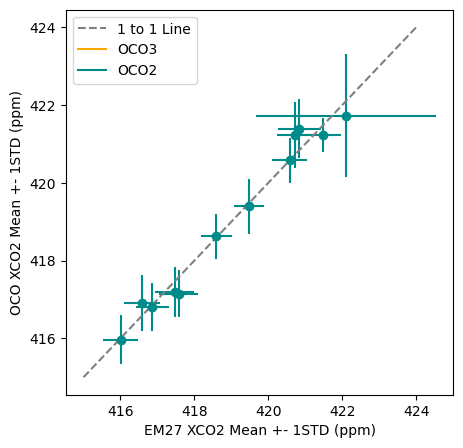

In [29]:
radius = 10000
fig,ax = plt.subplots(figsize = (5,5))

for oco_type in oco_em27_dicts.keys():
        oco_em27_dict = oco_em27_dicts[oco_type][radius]
        comparison_df_oco = pd.DataFrame(oco_em27_dict).transpose()
        if oco_type =='oco2':
                color = 'darkcyan'
        else:
                continue
                color = 'orange'
        ax.errorbar(comparison_df_oco['em27_xco2_mean'],comparison_df_oco['oco_xco2_mean'],
                    xerr=comparison_df_oco['em27_xco2_std'],
                    yerr=comparison_df_oco['oco_xco2_std'],
                    color = color,fmt='o')
ax.plot(range(415,425),range(415,425),'--',color = 'grey',label = '1 to 1 Line')
ax.plot([],[],color = 'orange',label = 'OCO3')
ax.plot([],[],color = 'darkcyan',label='OCO2')
ax.set_ylabel('OCO XCO2 Mean +- 1STD (ppm)')
ax.set_xlabel('EM27 XCO2 Mean +- 1STD (ppm)')
ax.legend()
plt.show()

## Plot all comparisons on a map

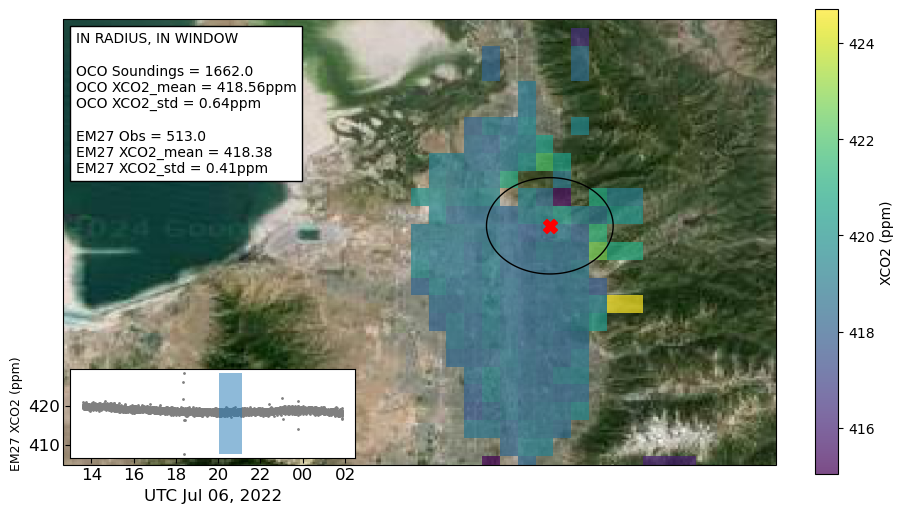

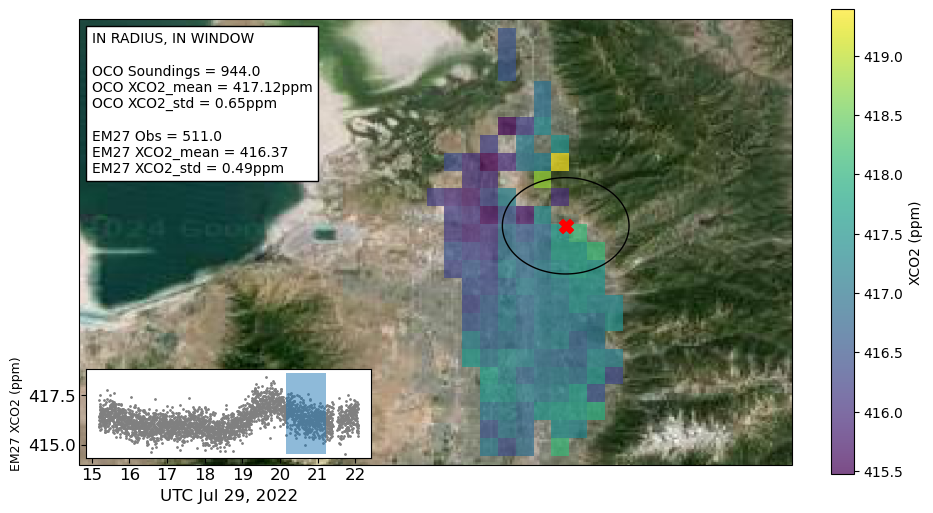

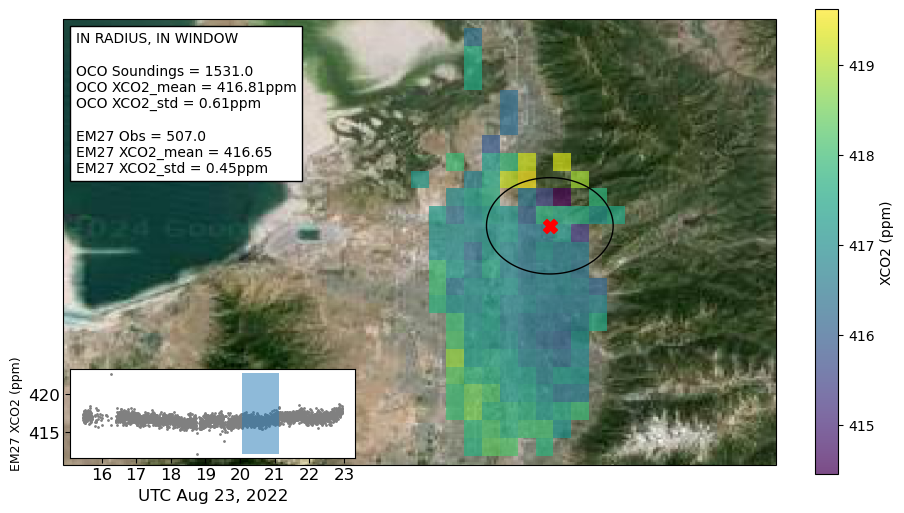

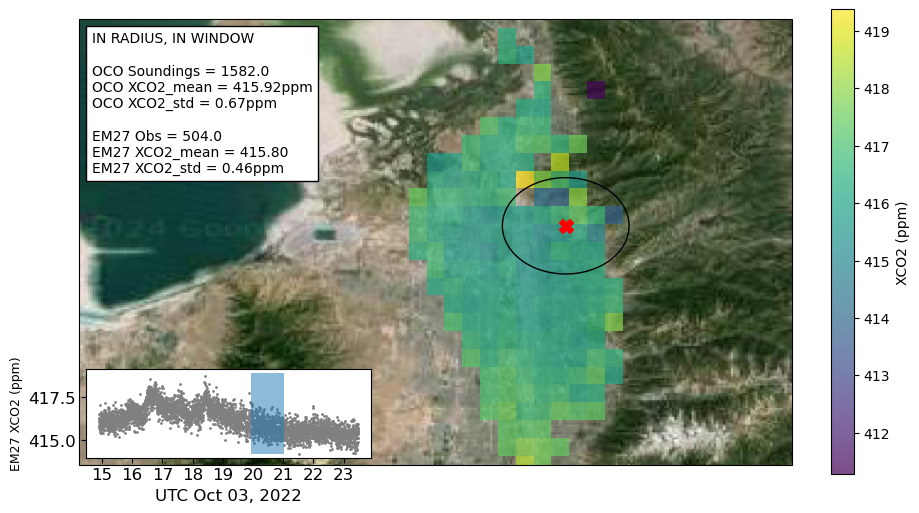

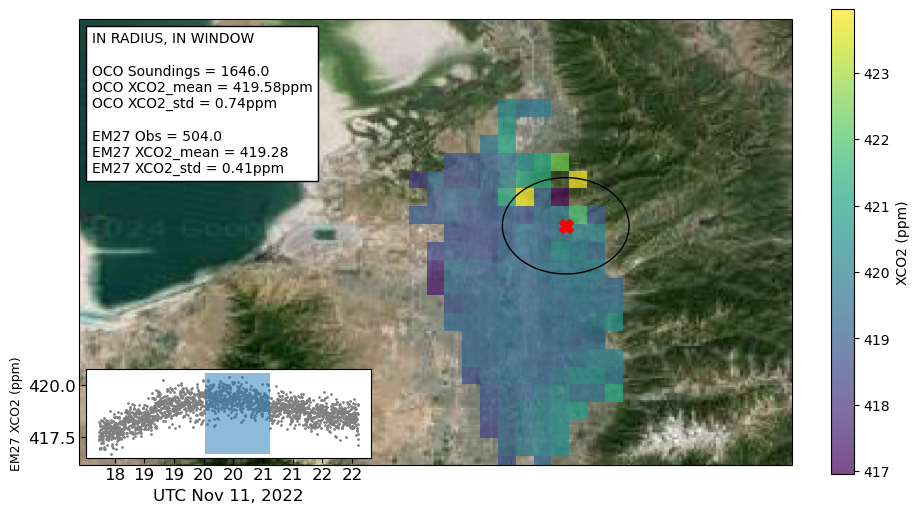

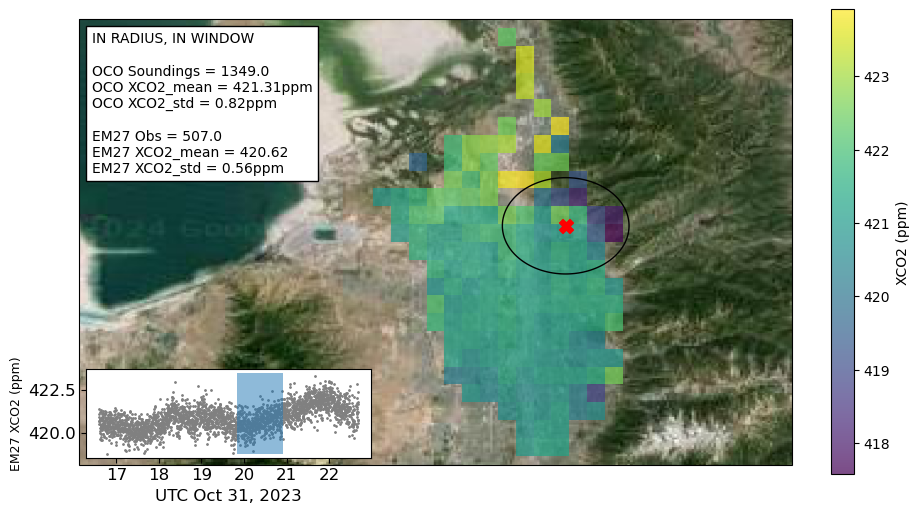

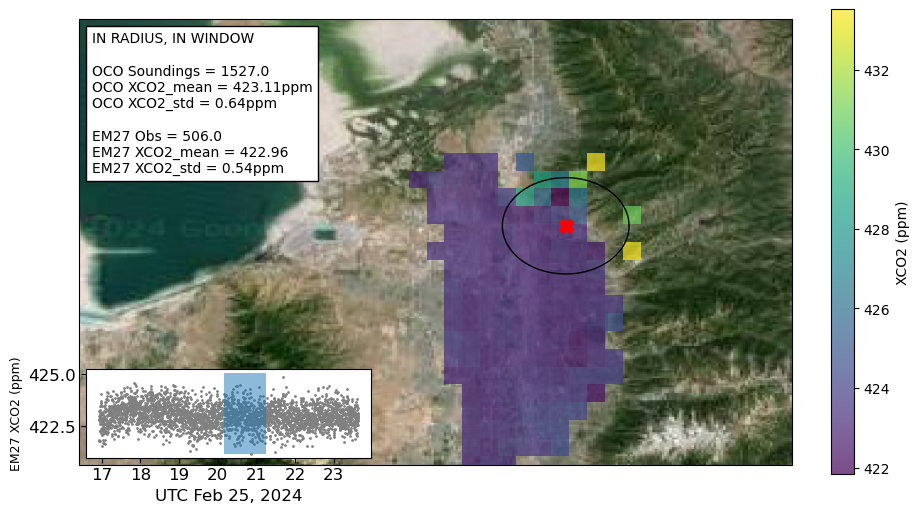

In [10]:
map_extent={'lon_low':-112.4,
            'lon_high':-111.6,
            'lat_low':40.5,
            'lat_high':41.0}

days_with_data = {}
for oco_type in oco_data_folders.keys():
    days_with_data[oco_type] = {}
    for oco_target_date in oco_target_dates[oco_type]:
        date = datetime.datetime.strptime(oco_target_date,'%Y-%m-%d')
        oof_filename = oco.check_for_oof_file(oof_data_folder,date)
        oco_filename = oco.check_for_oco_file(oco_data_folders[oco_type],date)
        if (oof_filename is not None) & (oco_filename is not None):
            days_with_data[oco_type][oco_target_date] = {'oof_filename':oof_filename,'oco_filename':oco_filename}

# offset_dict = {'xch4(ppm)': -0.00037187162724938716,
#  'xco2(ppm)': -0.8293283118730983,
#  'xco(ppb)': 6.493298023365156}
offset_dict = None

oco_em27_dicts = {}
for oco_type in oco_data_folders.keys():
    oco_em27_dicts[oco_type] = {}
    oco_data_folder = oco_data_folders[oco_type]
    for radius in [6000]:#,8000,10000]:
        oco_em27_dicts[oco_type][radius] = {}
        for day in days_with_data[oco_type].keys():
            oco_filename = days_with_data[oco_type][day]['oco_filename']
            oco_df = oco.load_oco_df(os.path.join(oco_data_folder,oco_filename),quality_flag=0)
            trimmed_oco_df = oco.trim_oco_df_to_extent(oco_df,trim_extent)
            if len(trimmed_oco_df)==0:
                print(f"No OCO data in trim_extent for {day}")
                continue
            trimmed_oco_df = oco.add_oco_inradius_column(trimmed_oco_df,inst_loc,radius)
            inradius_oco_df = trimmed_oco_df.loc[trimmed_oco_df['inradius']]
            if len(inradius_oco_df)==0:
                print(f"No OCO data inradius for {day}")
                continue
            inradius_oco_details = oco.get_oco_details(inradius_oco_df)

            date = datetime.datetime.strptime(day,'%Y-%m-%d')
            oof_filename = oco.check_for_oof_file(oof_data_folder,date)
            my_oof_manager = ac.oof_manager(oof_data_folder,'UTC')

            oof_df = my_oof_manager.df_from_oof(oof_filename,fullformat = True, filter_flag_0=True)
            if len(oof_df) == 0:
                continue
            oof_df = oco.add_oof_inwindow_column(oof_df,inradius_oco_details,oof_surround_time)
            inwindow_oof_df = oof_df.loc[oof_df['in_oco_window']]
            if len(inwindow_oof_df) == 0:
                continue
            inwindow_oof_details = oco.get_oof_details(inwindow_oof_df)

            step_deg = 0.02
            binned_oco_xr = oco.bin_oco_soundings(trimmed_oco_df,step_deg)
            plot_text = oco.get_plottext_from_details(inradius_oco_details,inwindow_oof_details)

            labsize = 12
            proj = ccrs.PlateCarree()
            fig = plt.figure(figsize=(10,8))
            ax = plt.axes(projection = proj)
            ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
            request = cimgt.GoogleTiles(style='satellite')
            scale = 9.0 # prob have to adjust this
            ax.add_image(request,int(scale))

            map = binned_oco_xr['xco2'].plot.pcolormesh('lonbin','latbin',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False)
            ax.scatter(inst_loc['lon'],inst_loc['lat'],color = 'red',marker = 'X',s = 100)

            cp = Geodesic().circle(lon=inst_loc['lon'],lat=inst_loc['lat'],radius = radius)
            geom = sgeom.Polygon(cp)
            ax.add_geometries(geom,crs=proj,edgecolor = 'k',facecolor='none')

            at = AnchoredText(plot_text, loc='upper left', frameon=True, borderpad=0.5, prop=dict(size=10))
            ax.add_artist(at)

            axins = inset_axes(ax,width='40%',height='20%',loc='lower left')
            axins.scatter(oof_df.index,oof_df['xco2(ppm)'],color = 'grey',zorder=3,s=1)
            if inradius_oco_details is not None:
                    window_base = (min(oof_df.loc[oof_df['in_oco_window']].index),min(oof_df['xco2(ppm)']))
                    width = max(oof_df.loc[oof_df['in_oco_window']].index)-min(oof_df.loc[oof_df['in_oco_window']].index)
                    height = max(oof_df['xco2(ppm)'])-min(oof_df['xco2(ppm)'])+0.2
                    rect = mpatches.Rectangle((window_base),width,height,zorder = 10,alpha = 0.5)
                    axins.add_patch(rect)
            axins.tick_params(labelsize = labsize)
            axins.set_ylabel('EM27 XCO2 (ppm)',size = labsize-3)
            #axins.set_ylim([415,425])
            axins.xaxis.set_major_formatter(mdates.DateFormatter('%H', tz = datetime.timezone.utc))
            axins.set_xlabel(oof_df.index[0].strftime('%Z %b %d, %Y'),size = labsize)
            plt.gcf().autofmt_xdate()
            plt.colorbar(map,fraction=0.03,label ='XCO2 (ppm)')
            plt.show()